In [1]:
from pathlib import Path
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

import sys, os
from tqdm.autonotebook import tqdm

sys.path.insert(0, os.path.abspath('..'))
from src.invite import sample_censored, graph_random_walk
from src.analysis import draw_G

import utils.plot_utils as pu
# import torch
# import torch.nn.functional as f

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/tbsexton/miniconda3/envs/eng-net/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
pu.figure_setup()

net_path = Path('..')/'data'/'randomgraphs_serial'
latex_path = Path('..')/'idetc19-latex'/'img'

## Test Network
First we want to make a netork that is somewhat reasonable. From literature, typical verbal/semantic fluency networks have a clustering coefficient $C_\beta \approx 0.29.$ We solve for the re-wiring coefficient needed to synthesize a watts-strogatz network with that $C_\beta$ on average. 

In [3]:
from sympy import symbols, solve, Eq
K, β, C_β = symbols('K β C_β')
# K is the mean degree of a Watts-Strogatz network (given as 4)
# β is the probability of re-wiring an edge during construction

C_0 = (3*K-6)/(4*K-4)
clust_coef = Eq(C_β, C_0*(1-β)**3)

# now solve for β using params from Zemla et al.
beta = solve(clust_coef.subs({C_β:0.29, K:4}), β)[0]  
print(f'β ≈ {beta:.6f}')

β ≈ 0.166045


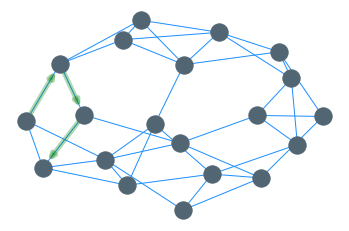

In [5]:
# let's generate a graph G
N = 20
G = nx.watts_strogatz_graph(N, 4, beta)
# M = [graph_random_walk(G, steps=100).unique()[:4] for i in tqdm(range(20))]
M = sample_censored(G, n_walks=25, n_obsv=4, steps=100, demo=False)


A = nx.to_numpy_array(G)#[order,:][:,order]


pos = nx.layout.kamada_kawai_layout(G)
draw_G(G, pos)
a = M[3]
edgelist = [(a[n],a[n+1]) for n in range(len(a)-1)]
nx.draw_networkx_edges(nx.DiGraph(G),pos=pos,edgelist=edgelist, 
                       width=5, alpha=.3, edge_color='green');

Using both as a explanatory, toy example, and as a mini synthetic experiment

--> split these out

show it first, to motivate, later bring it up by "returning to the watts-strogatz", to return to something we've seen before

<IPython.core.display.Javascript object>


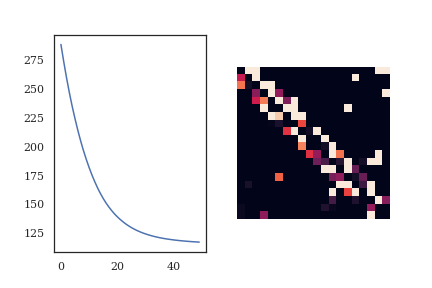

In [6]:

%matplotlib notebook
from src.models import CensoredRW, train
model = CensoredRW(N, sym=True)


learning_rate = 0.1

train(model, np.array(M), batch_size=None, compare_true=A,
      epochs=50, callback=True, lr=learning_rate)

%matplotlib inline

In [80]:
from src.tools import cosine_model, markov_model, hidden_markov, minmax, symmetrize
from src.analysis import test_multi, compare_mats, compare_pvr

res = model.P.detach().cpu().numpy()

prep = lambda A: minmax(symmetrize(A))

mkv1 = markov_model(M, k=1)
# mkv2 = markov_model(M, k=2)
mkv2 = hidden_markov(M, max(map(len, M)), N)
cos = cosine_model(M)

models = dict(
    INVITE=prep(res), 
    Cosine=prep(cos), 
    MC=prep(mkv1), 
    HMM=prep(mkv2),
)

In [81]:
models['HMM'].shape
# np.array(M)

(20, 20)

/home/tbsexton/Documents/Code/eng-net/src/analysis.py:227: RuntimeWarning: invalid value encountered in true_divide
  f = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1])


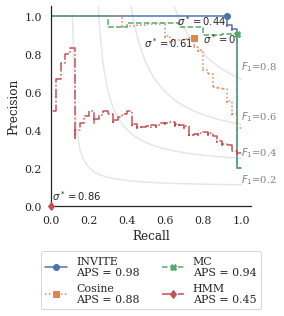

In [82]:
from src.analysis import test_multi, compare_mats, compare_pvr
log = test_multi(A, **models)

compare_pvr(A, store=log)

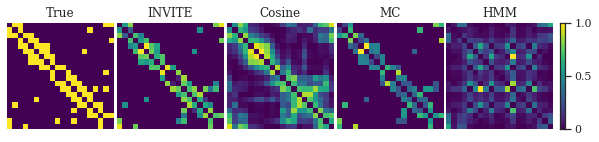

In [83]:
plt.figure(figsize=(10,3))
compare_mats(A, **models);

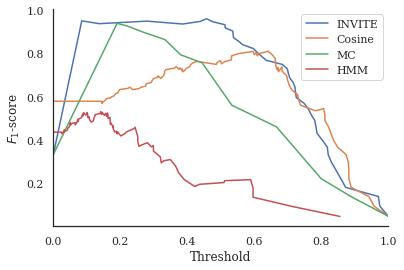

In [84]:
for name, d in log.items():
    plt.plot(d['t'], d['f'], label=name)
    plt.legend(loc=0)
    plt.xlabel('Threshold')
    plt.ylabel('$F_1$-score')
    plt.xlim(0,1)
sns.despine()

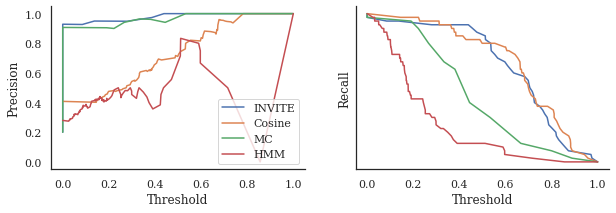

In [85]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,3))
for name, d in log.items():
    ax[0].plot(d['t'], d['p'], label=name)
    ax[0].legend(loc=0)
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Precision')
    ax[1].plot(d['t'], d['r'], label=name)
#     ax[1].legend(loc=0)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Recall')
#     plt.xlim(0,1)
sns.despine()

Is this a straw-man? Here, say that performance as such is not important, it's failure *modes* of the two paradigmatic extremes, and that some kind of continuum *exists*...start this section with that disclaimer?

In [89]:
storestr = ('graphs30_nodes10-25-50'
            '_nwalks10-25-50_length4_seed8')
df = pd.read_feather(net_path/storestr)

df = df.assign(**{
    '$\sigma$':lambda x: x['t'].round(decimals=1)
#     '$\sigma$': df.groupby(['nodes', 'model']).rolling(10).t.mean().reset_index().t
})

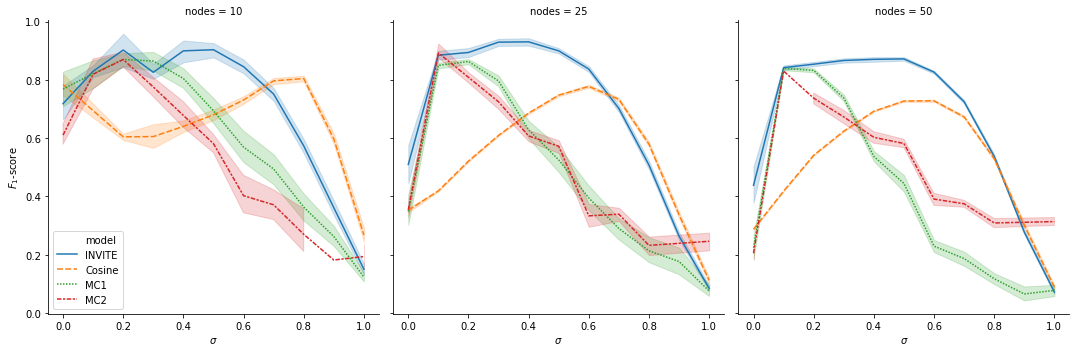

In [90]:
# pu.figure_setup()
# plt.figure()
g = sns.relplot(data=df, x='$\sigma$', y='f', 
            hue='model', col='nodes', kind='line', style='model',
               facet_kws={"hue_order":['INVITE','Cosine','MC1','MC2'],
                          "hue_kws":dict(linestyle=['-', ':', '--', '-.']),
                          'legend_out':False
                         },
#                height=pu.TEXT_HEIGHT/3., aspect=pu.TEXT_WIDTH/pu.TEXT_HEIGHT
               )
g.set(ylabel='$F_1$-score')
# plt.gcf().set_size_inches(*pu.figsize(columns=2, fig_height=pu.TEXT_HEIGHT/4.))
# plt.tight_layout()
# g.axes[0][0]
# plt.legend(loc='upper center',
#                bbox_to_anchor=(0.5, -0.5),
#                ncol=2)
# g.axes[0][0].legend()

# g. map(plt.axhline, 0.5, color='k', ls=':')

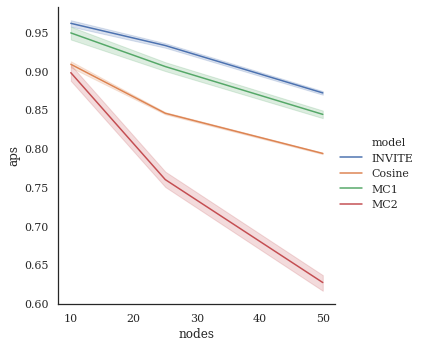

In [104]:

sns.relplot(data=df, x='nodes', y='aps', hue='model', kind='line')
# 

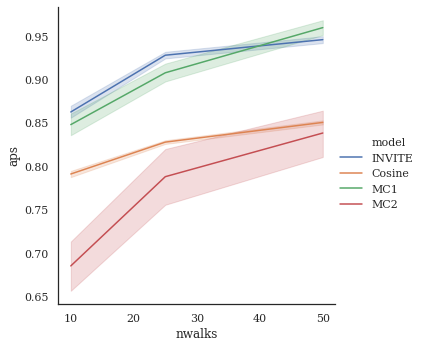

In [98]:
sns.relplot(data=df, x='nwalks', y='aps', hue='model', kind='line')

## OLD (working it out)

/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


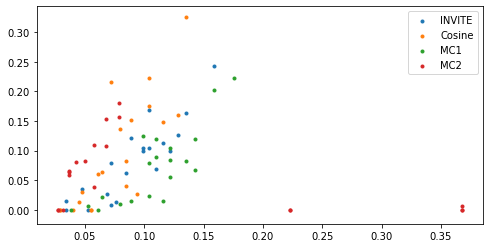

In [11]:
plt.figure(figsize=(8,4))
for mod in log.keys():
    
    D = nx.from_numpy_array(log[mod]['thres'])

    path = lambda n: np.array(list(
        dict([(k,v) for k,v in nx.single_target_shortest_path_length(D, n) if k is not n])
        .values()
    )).mean()
    plt.scatter(list({n:np.exp(-1*path(n)) for n in D.nodes}.values()), 
                  list(nx.betweenness_centrality(D).values()), label=mod, marker='.')
    
plt.legend()


In [3]:
# let's generate a graph G
N = 10
G = nx.watts_strogatz_graph(N, 4, .166)
m = [graph_random_walk(G).unique()[:5] for i in range(10)]
A = nx.to_numpy_array(G)
m[0]

array([7, 8, 4, 3, 2])

/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


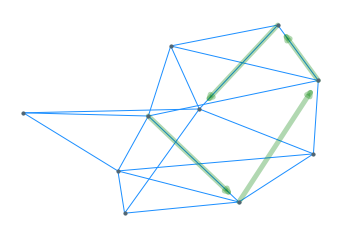

In [5]:
pos = nx.layout.kamada_kawai_layout(G)
draw_G(G, pos)
a = m[4]
edgelist = [(a[n],a[n+1]) for n in range(len(a)-1)]
nx.draw_networkx_edges(nx.DiGraph(G),pos=pos,edgelist=edgelist, 
                       width=5, alpha=.3, edge_color='green');


(4, 4) (4, 2)
(10, 10) (10, 10)
False


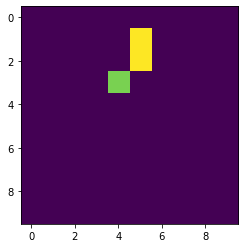

In [6]:
T = A/A.sum(axis=1)
a = list(m[4]) + list(set(range(T.shape[0])) - set(m[4]))
idx=4
n = T.shape[0]

a_trans, a_absrb = a[0:idx], a[idx:len(a)-idx]

Q = T[a_trans, :][:, a_trans]
R = T[a_trans, :][:, a_absrb]
I = np.identity(Q.shape[0])
print(Q.shape, R.shape)
P = np.dot(np.linalg.pinv(I-Q), R)


Qp = np.pad(Q, (0,n-idx), 
            mode='constant')
Rp = np.pad(R, 
            [(0,n-idx),
             (idx, n-len(a_absrb)-idx)],
            mode='constant')
print(Qp.shape, Rp.shape)
Pp = np.dot(np.linalg.pinv(np.eye(n)-Qp), Rp)
# plt.imshow(Qp)
plt.imshow(Rp)
print(Pp[idx-1, 0] == P[-1,0])

In [7]:
print(Pp)
print(P)

[[0.         0.         0.         0.         0.02030457 0.14593909
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00406091 0.27918782
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.07715736 0.30456853
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.21928934 0.07614213
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0. 

In [8]:

# x = torch.from_numpy(T).float()
x = torch.rand(N,N).float().requires_grad_(True)
index = torch.LongTensor(a)#.requires_grad_(False)
# y = torch.zeros_like(x)
t = f.normalize(torch.exp(x), p=1)[index][:,index]


In [9]:
i = torch.ones(N,N).triu().repeat(N,1,1).permute(2,0,1)#.requires_grad_(False)
j = torch.ones(N,N).triu().repeat(N,1,1).permute(2,1,0)#.requires_grad_(False)

q_ma = (j*i)[:4]
r_ma = ((1-i)*j)[:4] - (j*i)[4].flip(1)*j[:4]
# r_ma[:4]
q_ma

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.,

In [10]:


q = t*q_ma
r = t*r_ma
p = torch.matmul(torch.inverse(torch.eye(N)-q), r)
like = p.diagonal().diagonal(offset=-1).log().sum()
loss = -1*like

loss.backward()

# x.grad
loss
# plt.imshow(p.sum(dim=0))
# [p[i] for i in list(zip(range(4), range(4), range(1,5)))]
# p.sum(dim=1), p[1]
# plt.spy(x)
# y[:,index] = x
# plt.spy(y)

tensor(8.4159, grad_fn=<MulBackward0>)

In [11]:
loss.item()

8.415854454040527